In [217]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [218]:
words = open('names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [219]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, '.')

stoi = {c:i for i,c in enumerate(chars)}
itos = { i:c for i,c in enumerate(chars)}
vocab_size = len(itos)

In [220]:
import random

block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w:
            ix = stoi[ch]
            X.append(context)
    
            Y.append(ix)
            # print(''.join(itos[i] for i in context), ' --->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y. shape)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([156999, 3]) torch.Size([156999])
torch.Size([19452, 3]) torch.Size([19452])
torch.Size([19662, 3]) torch.Size([19662])


In [221]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g) # 2 col embedding vector for each character
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) # input is 6 as we are passing in 3 chars as inputs, 
# but in there embedding form (so 3 embeddings flattened). 100 out is design choice
b1 = torch.randn(n_hidden, generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(f"Total number of params: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Total number of params: 11897


      0/ 200000: 3.2974
  10000/ 200000: 2.4987
  20000/ 200000: 2.1232
  30000/ 200000: 1.9750
  40000/ 200000: 2.8610
  50000/ 200000: 1.9201
  60000/ 200000: 1.6206
  70000/ 200000: 2.1686
  80000/ 200000: 2.2651
  90000/ 200000: 2.2406
 100000/ 200000: 2.1395
 110000/ 200000: 2.0777
 120000/ 200000: 2.1902
 130000/ 200000: 2.3681
 140000/ 200000: 1.9442
 150000/ 200000: 2.2748
 160000/ 200000: 2.2125
 170000/ 200000: 2.0743
 180000/ 200000: 2.6403
 190000/ 200000: 2.6075


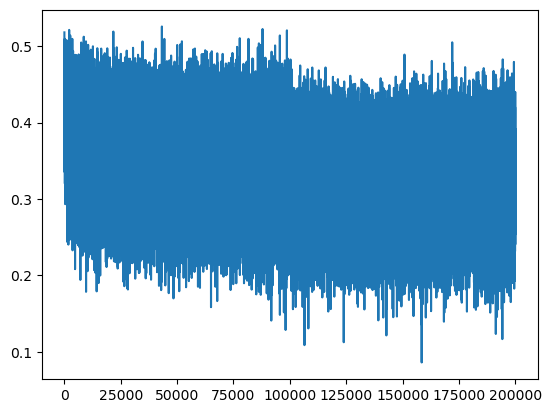

In [222]:


lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre
lri = []
lossi = []
iz = []

batch_size = 32
max_steps = 200000



for i in range(max_steps):
    ## construct minibatch indexes
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    ## forward pass
    emb = C[Xb]
    h = torch.tanh(emb.view(-1, int(C.shape[1] * X.shape[1])) @ W1 + b1) # (word-grams, 100)
    logits = h @ W2 + b2 # (100, 27)
    loss = F.cross_entropy(logits, Yb)
    # print(f"Loss at epoch {k}: {(loss.item()):.4f}, lr was {lrs[k]:.4f}") 
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # lr = 0.0001
    #update
    for p in parameters:
        p.data += -lr * p.grad

    # #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    iz.append(i)
    # lri.append(lrs[k])
    
    
# plt.plot(lri, lossi)

plt.plot(iz, lossi)

In [208]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (test rows, block_size ) indexing a (word_size, n_embed) => (n_rows, block_size, n_embed) )
    embcat = emb.view(emb.shape[0], -1) # (n_rows, embed_size * block_size * n_embed)
    h = torch.tanh( embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')






train 3.0381414890289307
val 3.038398265838623


In [ ]:
for _ in range(20):
    out = []
    context = [0] * block_size #(3)
    while True:
        emb = C[torch.tensor([context])] # (1, 3) indexing a (27, 2) => (1, 3, 2)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (1, 6) @ (6, 100)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))